# Line noise

wanted to try [Piralta 2002](https://doi.org/10.1006/jnca.2002.0142) NN (or maybe just SVM) of difference images, but there is too much noise!

This notebook turned into experiments measuring the noise.

There is likely a bandpass or fft solution. should look into that too

In [193]:
import os
import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.fftpack import rfft, irfft, fftfreq, fft

# load our code
sys.path.insert(0, os.path.abspath('../'))
from plotting import auto_draw
# specific to jupyter notebook
from jupyter_help import cvplt, cvplt_sub
#Import image processing function from optimization
# load any changes as we make them
%load_ext autoreload
%autoreload 2

vid_fname = "../input/run1.mov"
vs = cv2.VideoCapture(vid_fname)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Image differences
from one frame to the next the average and the difference are very noisy

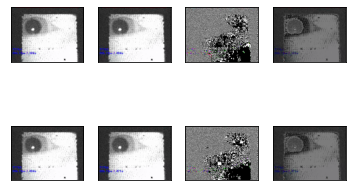

In [175]:
def get_frame(i):
    "frame at pos"
    vs.set(1, i)
    return vs.read()[1]
def avg_frame(f1,f2):
    return np.array((f1+f2)/2, dtype=int)

frames = [get_frame(i) for i in range(200,210)]

# mean each frame
cvplt_sub([frames[0], frames[1], (frames[0]-frames[1]), avg_frame(frames[0], frames[1]),
           frames[1], frames[2], (frames[1]-frames[2]), avg_frame(frames[1],frames[2])],2 ,4)

looking at every other doesn't help. the period of the scrolling lines is not a scale of 60Hz


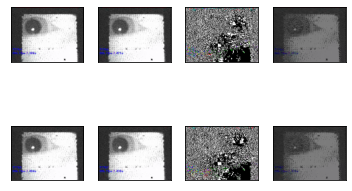

In [176]:
# every other
cvplt_sub([frames[0], frames[2], frames[0]-frames[2],avg_frame(frames[0],frames[2]),
          frames[1], frames[3], frames[1]-frames[3],avg_frame(frames[1],frames[3])],2 ,4)

The average of sequential frames does an interesting thing around the pupil.
is the difference of averages interesting?


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


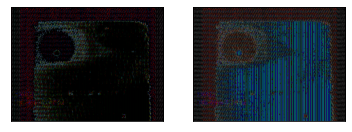

In [198]:
avg1 = avg_frame(frames[0], frame[1])
avg2 = avg_frame(frames[1], frames[2])
cvplt_sub([avg1-avg2,abs(avg1-avg2)],1,2)

## What is the nosie?
diagonal lines that scroll through the video

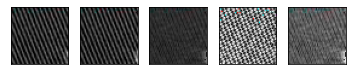

In [177]:
one=frames[0][2:50,2:50]
two=frames[1][2:50,2:50]
cvplt_sub([one, two, avg_frame(one,two), one-two, one+two],1,5)

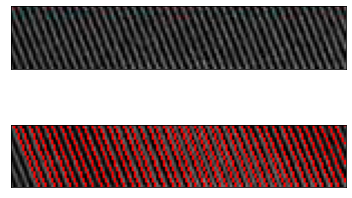

In [178]:
frame_line = frames[0].copy()[2:30,0:XMAX]
XMAX = 150 # lmit viewing to this width
Y = 0

# parameters to optimize
X0 = 1
M = 2.5 
W = 3.53


def find_end(x, m):
    x2 = XMAX    # end far off the screen
    y2 = int(Y-m*(x-x2))
    return (x2, y2)
def draw_line(frame):
    for x in np.arange(X0, XMAX, W):
        cv2.line(frame, (int(x),0), find_end(x, M), (255,0,0), 1)
    return(frame)

example = draw_line(frame_line.copy())
cvplt_sub([frame_line, example],2,1)

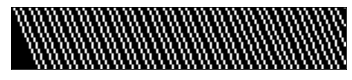

In [192]:
mask = np.zeros((28,XMAX,3), np.uint8)
mask = draw_line(mask)
i = np.where(mask>0)
# TODO: mask image. take diff of masked image

## remove rgb color (reduce to 2D)



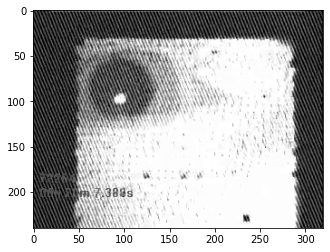

In [205]:
# meaning the colors does a good job keeping gray...gray
x=np.mean(frames[0],axis=2)
plt.gray() # set implot color scale to gray -- otherwise we get a heatmap of our gray image
plt.imshow(x)

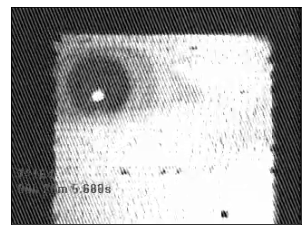

(240, 320)

In [287]:
def get_frame_sm_gray(i):
    "frame at pos"
    vs.set(1, i)
    frm = vs.read()[1]
    # sm = frm[2:30, 0:frm.shape[1]]
    sm = frm
    gry = np.mean(sm, axis=2)
    return gry

example = get_frame_sm_gray(100)
cvplt(example)
example.shape

In [256]:
img_time = np.stack([get_frame_sm_gray(i) for i in range(0,300)],axis=2)
img_time.shape

(240, 320, 300)

## Collect across Time

We've concated the first 300 images. Lets look at what should be totally black points over time.

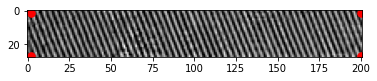

In [262]:
h=plt.imshow(img_time[2:30,0:201,20])
h=plt.plot( [2,200,2,200], [1,1,27,27], 'r.', markersize=15)

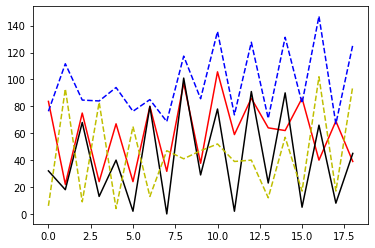

In [263]:
h = plt.plot(img_time[1,2,1:20], 'r-')    
h = plt.plot(img_time[1,200,1:20],'b--')  # horz=200
h = plt.plot(img_time[27,2,1:20], 'k-')
h = plt.plot(img_time[27,200,1:20],'y--') # horz=200

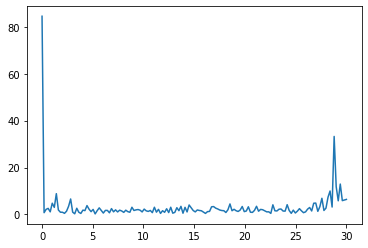

In [270]:
y = img_time[2,2,:]
N = len(y)
T = 60 # is this right? 60Hz, or should it be 1/60. x goes to 30 in the plot seems right
yf = fft(y)
xf = np.linspace(0.0, 1.0/2*T, N//2)
plt.plot(xf, 2.0/N * abs(yf[:N//2]))

Can we cut out anything greater than 25Hz? Will that kill saccades? Does it matter for our task?  Using 
https://stackoverflow.com/questions/39799821/how-to-remove-frequency-from-signal


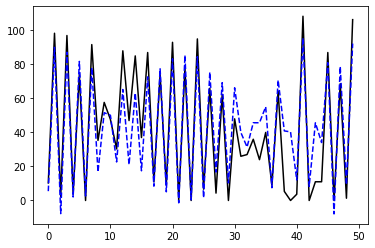

In [289]:
f_signal = rfft(y)
x = np.linspace(0.0, (N-1)*(1/T), N) # HERE: was T chagned to 1/T
W = fftfreq(y.size, d=x[1]-x[0])
cut_f_signal = f_signal.copy()
cut_f_signal[(W>1/25)] = 0  # filter all frequencies above 0.6
cut_signal = irfft(cut_f_signal)
h=plt.plot(y[:50],'k-')
h=plt.plot(cut_signal[:50],'b--')